# Single Cell RNA-Seq analysis with Seurat
*Waldeyr Mendes Cordeiro da Silva; compiled on Mar-2021*

## Case Study

This case study is part of the Chapter "Transcriptome Analysis Throughout RNA-seq" by Brigido et al.

Single-cell RNA-Seq (scRNA-Seq) profiles gene expression of individual cells that can be identified by Unique Molecular Identifiers (UMIs).

Fang Li et al. (2020) have conducted a study using single-cell transcriptome sequencing (scRNA-seq), single-cell BCR sequencing (scBCR-seq), and deep BCR repertoire in order to reveal neutralizing antibody sequences in patients who have recently cleared the virus.
They collected blood samples (Peripheral blood mononuclear cells - PBMCs) from 16 COVID-19 patients and 8 healthy controls to reveal the changes of immune cells caused by SARS-CoV-2 infection. 

This case study uses a single sample of the Fang Li et al. (2020) dataset to demonstrate how to identify distinct types of cells based on their transcripts.
For that we filtered the data to work only with P3 and P10 samples. 
These samples are both from female 59 years old COVID-19 patients with distinct levels of  severity.
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

Data is available in https://zenodo.org/record/3744141.


Li, F., Luo, M., Zhou, W., Li, J., Jin, X., Xu, Z., ... & Jiang, Q. (2020). Single cell RNA and immune repertoire profiling of COVID-19 patients reveal novel neutralizing antibody. Protein & cell, 1-5.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.12")

BiocManager::install('ggplot2')
BiocManager::install('ggrepel')
BiocManager::install('limma')
BiocManager::install('calibrate')
BiocManager::install('dplyr')
BiocManager::install('Matrix')
BiocManager::install('Seurat') # It requires R version 4.x

In [1]:
options(warn=-1)

library(limma)
library(calibrate)
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)
library(ggrepel)

packageVersion("limma")
packageVersion("calibrate")
packageVersion("dplyr")
packageVersion("Matrix")
packageVersion("Seurat")
packageVersion("ggplot2")
packageVersion("ggrepel")

Loading required package: MASS


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



[1] ‘3.46.0’

[1] ‘1.7.7’

[1] ‘1.0.5’

[1] ‘1.3.2’

[1] ‘4.0.1’

[1] ‘3.3.3’

[1] ‘0.9.1’

Download and read data from https://zenodo.org/record/3744141

In [79]:
#system("wget https://zenodo.org/record/3744141/files/COVID-19.tar.gz")
#system("tar -xzvf COVID-19.tar.gz")
covid_19_data <- Read10X(data.dir = "COVID-19")
dim(covid_19_data) # dimensions for full data

[1] 33538 96404

Filtering data to work only with P3 and P10 samples. 
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

In [80]:
p3_and_p10_data <- covid_19_data[, grep(pattern = "P3|P10", colnames(covid_19_data))]
dim(p3_and_p10_data) # dimensions for selected data

[1] 33538 16056

Initialize the Seurat object with the raw (non-normalized data) constrained by the following parameters:
* minimal of two cells with at least 20 expressed genes and at least 2000 features.


In [81]:
covid_p3_p10 <- CreateSeuratObject(
    counts = p3_and_p10_data, 
    project = "COVID-19", 
    min.cells = 2, 
    min.genes = 20, 
    min.features = 2000
)
dim(covid_p3_p10)

[1] 17169  2123

Create a column to identify the patients. It is going to be useful for some plots.

In [82]:
covid_p3_p10[["patient"]] <- sapply(strsplit(colnames(covid_p3_p10),"-"), `[`, 1)
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient
,<fct>,<dbl>,<int>,<chr>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3


Before to start the data processing, let’s flag some information on these data. 
The [[]] operator can add columns to a object metadata. 
In this case, we stash QC stats mitochondrial samples, which are identified starting by "MT-"

In [83]:
covid_p3_p10[["perc_mitochondrial"]] <- PercentageFeatureSet(covid_p3_p10, pattern = "^MT-")
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial
,<fct>,<dbl>,<int>,<chr>,<dbl>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3,7.891094
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3,5.992722
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3,5.436613
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484


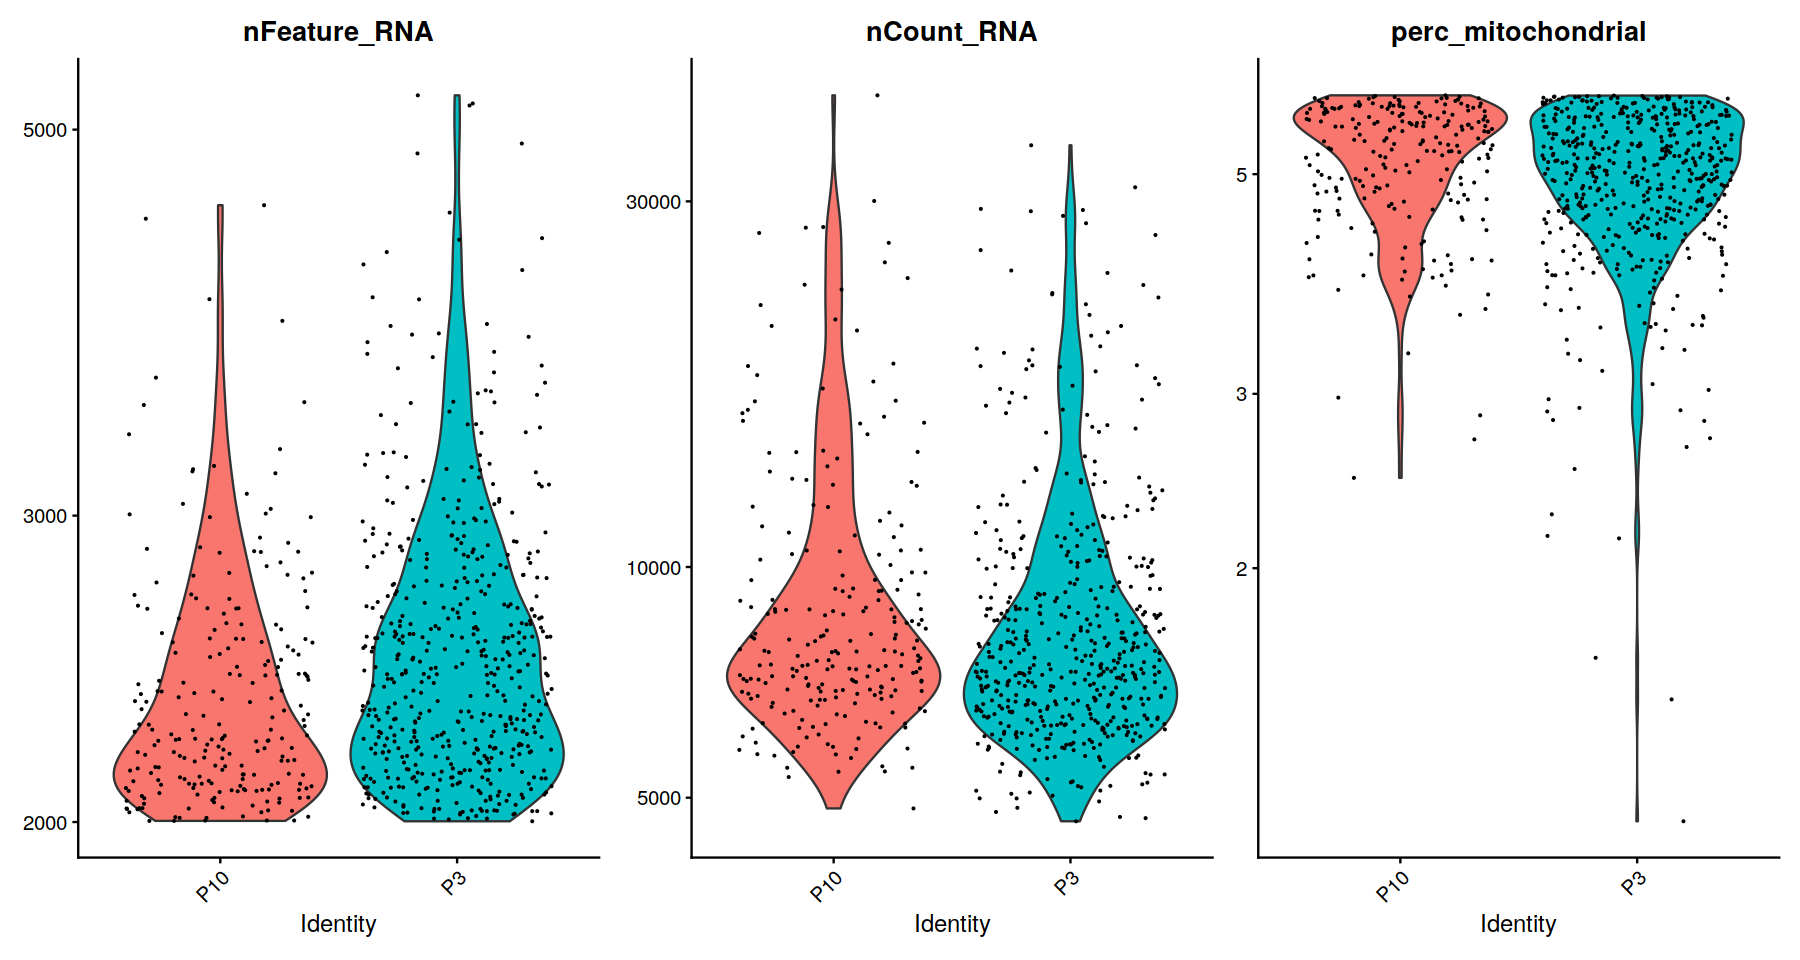

In [99]:
options(repr.plot.width=15, repr.plot.height=8)
plot_perc_mitochondrial <- VlnPlot(
    covid_p3_p10, 
    features = c("nFeature_RNA", "nCount_RNA", "perc_mitochondrial"), 
    ncol = 3, 
    group.by = "patient",
    log = TRUE
)
plot_perc_mitochondrial

Removing unwanted cells from the dataset. In this case we have applied a filter to keep only samples keeping the number of features at least equal to 2000, but with less than 5% of mitochondrial samples.

In [100]:
covid_p3_p10 <- subset(covid_p3_p10, subset = nFeature_RNA >= 2000 & perc_mitochondrial < 5)
dim(covid_p3_p10[[]])

[1] 746   5

The function LogNormalize() normalizes the feature expression measurements for each cell by the total expression It multiplies this by a scale factor (10,000 by default), and log-transforms the result. 
Normalized values will be stored in covid_p3_p10[["RNA"]]@data.

In [101]:
covid_p3_p10 <- NormalizeData(covid_p3_p10, normalization.method = "LogNormalize", scale.factor = 10000)
dim(covid_p3_p10[[]])

[1] 746   5

We can also generate a FeatureScatter, which is typically used to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc. In this case, it shows read count versus percentage of mitochondrial in a) and read count versus number of features in b)


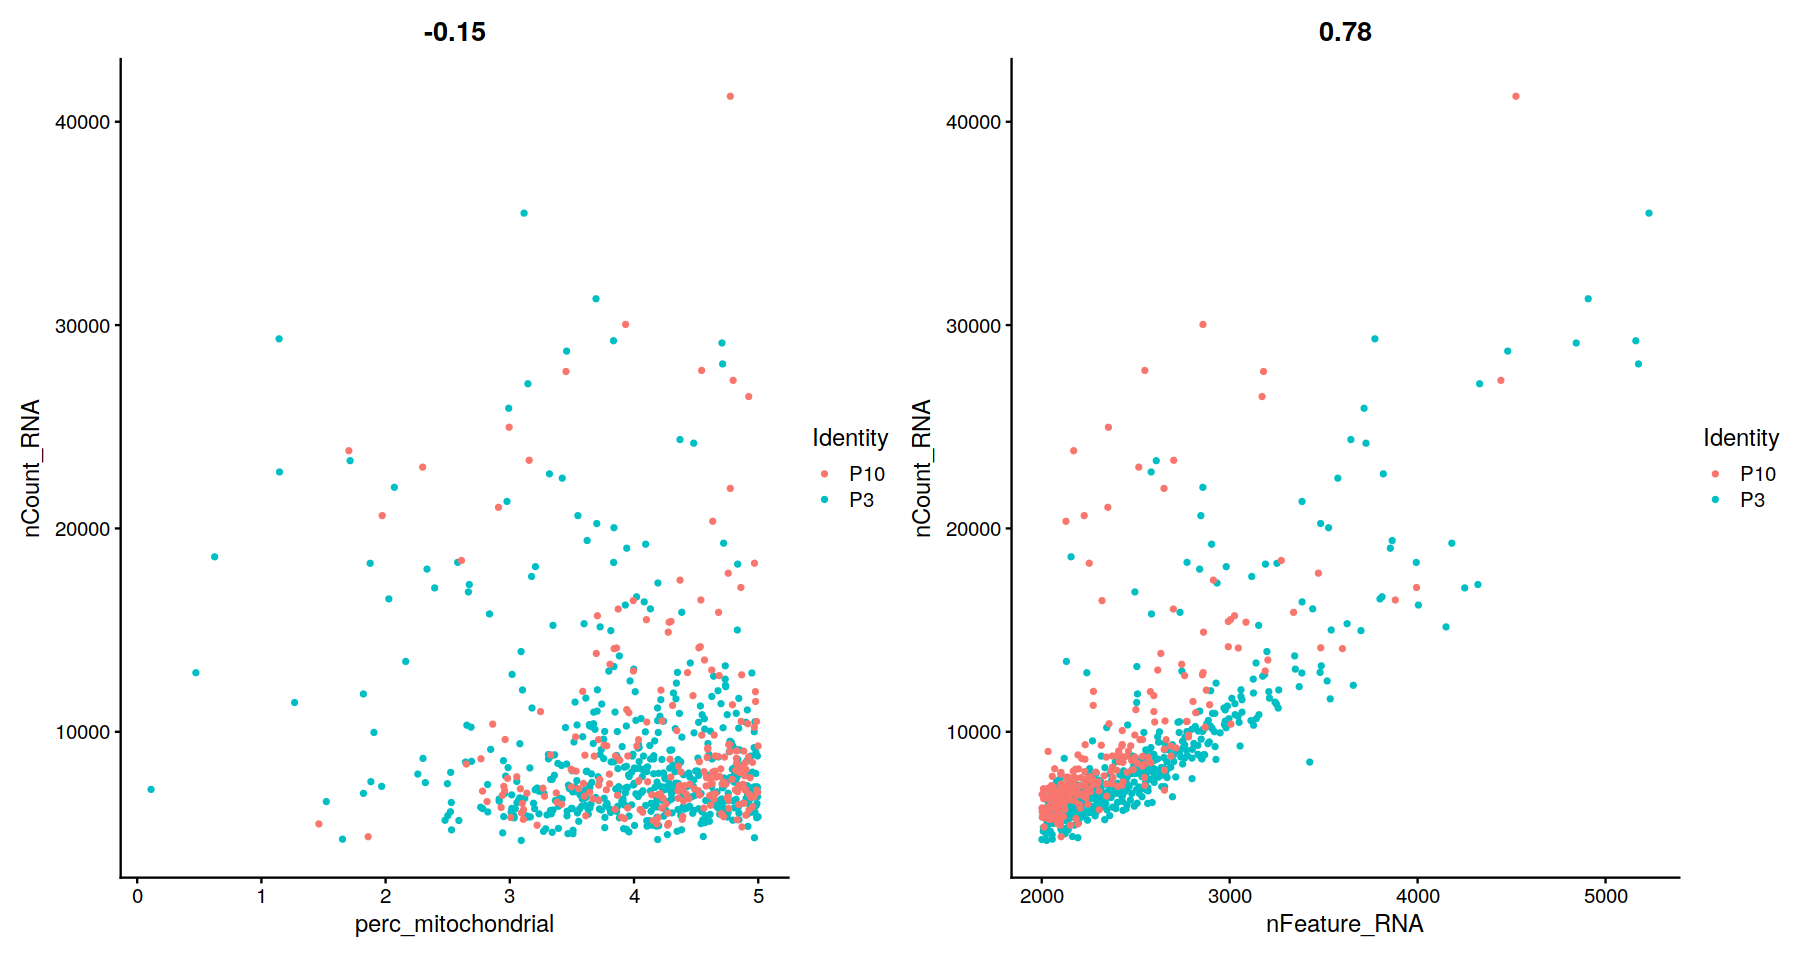

In [102]:
plot_feature_scatter_a <- FeatureScatter(
    covid_p3_p10, feature1 = "perc_mitochondrial", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_b <- FeatureScatter(
    covid_p3_p10, 
    feature1 = "nFeature_RNA", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_a + plot_feature_scatter_b

Once normalized, the next step is to identify highly variable features (feature selection)using the method vst which, according to the manual of Seurat, fits a line to the relationship of log (variance) and log (mean) using local polynomial regression (loess). Then, it standardizes the feature values using the observed mean and expected variance (given by the fitted line). The next step is to calculate the feature variance on the standardized values after clipping to a maximum (default is 'auto' which sets this value to the square root of the number of cells)

In [103]:
covid_p3_p10 <- FindVariableFeatures(covid_p3_p10, selection.method = "vst", nfeatures = 2000)
dim(covid_p3_p10[[]])

[1] 746   5

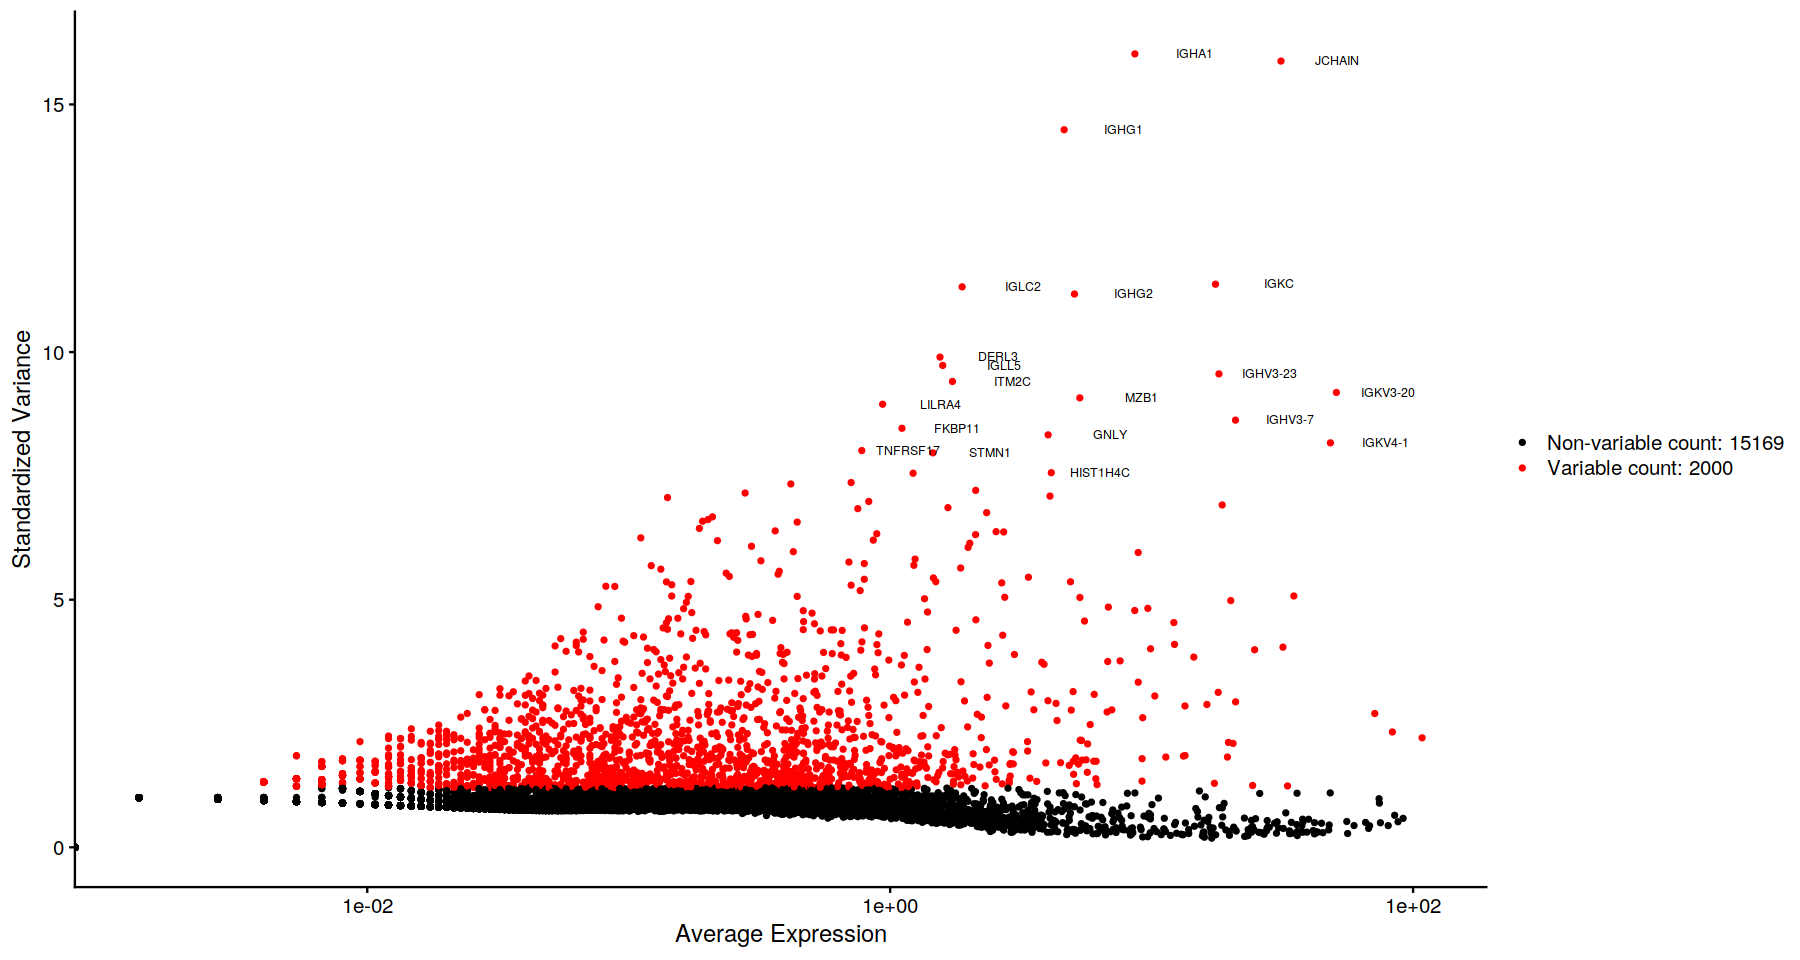

In [104]:
top20 <- head(VariableFeatures(covid_p3_p10), 20)
plot_top20 <- VariableFeaturePlot(covid_p3_p10) 
plot_top20 <- LabelPoints(plot = plot_top20, points = top20, size = 2.5, hjust = 1, vjust = .75) 
plot_top20

Now let’s take a look in the 20 most highly variable genes identified.

In [105]:
top20

[1] "IGHA1"    "JCHAIN"   "IGHG1"    "IGKC"     "IGLC2"    "IGHG2"   
 [7] "DERL3"    "IGLL5"    "IGHV3-23" "ITM2C"    "IGKV3-20" "MZB1"    
[13] "LILRA4"   "IGHV3-7"  "FKBP11"   "GNLY"     "IGKV4-1"  "TNFRSF17"
[19] "STMN1"    "HIST1H4C"

Before to perform the dimensional reduction, it is necessary perform a linear transformation scaling the data. It is a standard pre-processing step prior to apply techniques like PCA. 
* Scaling the data
* Linear dimensional reduction itself

In [106]:
all_genes_covid_p3_p10 <- rownames(covid_p3_p10)
covid_p3_p10 <- ScaleData(covid_p3_p10, features = all_genes_covid_p3_p10)
covid_p3_p10 <- RunPCA(covid_p3_p10, features = VariableFeatures(object = covid_p3_p10))

Centering and scaling data matrix

PC_ 1 
Positive:  PTPRCAP, CENPM, RRM2, MKI67, PTTG1, STMN1, PCLAF, C12orf75, TYMS, LIME1 
	   SEPT1, BIRC5, ZWINT, IL2RG, IL32, TRBC2, TMEM106C, HIST1H4C, MCM2, CD3D 
	   GINS2, LCK, MAD2L1, CLSPN, UBE2C, NPM1, ISG20, CD3E, SIT1, SUB1 
Negative:  CST3, S100A9, S100A8, IFITM3, S100A12, RETN, CFD, CPVL, FOS, DUSP6 
	   TMEM176B, MS4A7, CD36, CSF1R, RNASE2, PLBD1, CD163, AC020656.1, HLA-DRA, LGALS2 
	   CD300E, FCGR2A, TMEM176A, DUSP1, HLA-DRB1, CEBPD, HMOX1, APOBEC3A, GPBAR1, MAFB 
PC_ 2 
Positive:  JCHAIN, MZB1, DERL3, PPIB, ITM2C, SEC61B, HSP90B1, SSR4, IGKC, TNFRSF17 
	   SEC11C, PDIA4, SPCS1, CD74, TXNDC5, SSR3, BLNK, GNG7, SEL1L3, TMED10 
	   IGLL5, ST6GALNAC4, POU2AF1, ERLEC1, IRF4, LMAN1, TMEM258, HERPUD1, EAF2, SLAMF7 
Negative:  CAVIN2, TUBB1, GP9, AC147651.1, TSC22D1, CMTM5, TRIM58, MPIG6B, ABLIM3, TMEM40 
	   PF4, ESAM, MEIS1, TUBA8, PPBP, GATA1, GUCY1B1, AC090409.1, SELP, CLDN5 
	   LGALSL, RAB27B, MMD, DMTN, HIST1H3H, BMP6, LINC02284, SPAR

Now, let’s determine the dimensionality of the dataset. The function JackStraw() determines the statistical significance of PCA scores by randomically permuting a subset of data, and calculates projected PCA scores for these 'random' genes. Following, the ScoreJackStraw()  computes the scores significance by PCs showing a p-value distribution that is strongly skewed to the left compared to the null distribution.

In [108]:
covid_p3_p10 <- JackStraw(covid_p3_p10, num.replicate = 100)
covid_p3_p10 <- ScoreJackStraw(covid_p3_p10, dims = 1:5)

We can now cluster the cells. The function FindNeighbors() computes the k.param nearest neighbors for a given dataset using the k-nearest neighbors algorithm. Then, the function FindClusters() identifies clusters of cells from the SNN graph (result of the k-nearest neighbors algorithm). As higher is the resolution parameter as larger will be the communities. 


In [111]:
covid_p3_p10 <- FindNeighbors(covid_p3_p10, dims = 1:5)
covid_p3_p10 <- FindClusters(covid_p3_p10, resolution = 1)
head(Idents(covid_p3_p10), n = 5L)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 746
Number of edges: 19844

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8009
Number of communities: 10
Elapsed time: 0 seconds


P3-AAAGATGGTATCAGTC P3-AAAGATGTCGCTTGTC P3-AAATGCCTCACAACGT P3-AACACGTGTTTGACTG 
                  0                   1                   1                   1 
P3-AACACGTTCGTGGGAA 
                  0 
Levels: 0 1 2 3 4 5 6 7 8 9

Uniform Manifold Approximation and Projection (UMAP) is a dimensional reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. It is founded on three assumptions about the data: i) the data is uniformly distributed on a Riemannian manifold; ii) the Riemannian metric is locally constant (or can be approximated as such); iii) the manifold is locally connected.

[Caution: It takes some time.]

In [169]:
covid_p3_p10 <- RunUMAP(covid_p3_p10, dims = 1:5)
# It could be alternatively done using tSNE
#covid_p3_p10 <- RunTSNE(object = covid_p3_p10, dims.use = 1:5)

11:07:21 UMAP embedding parameters a = 0.9922 b = 1.112

11:07:21 Read 746 rows and found 5 numeric columns

11:07:21 Using Annoy for neighbor search, n_neighbors = 30

11:07:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:07:21 Writing NN index file to temp file /tmp/RtmpfcKHzJ/file1ac8b556c2a96

11:07:21 Searching Annoy index using 1 thread, search_k = 3000

11:07:21 Annoy recall = 100%

11:07:22 Commencing smooth kNN distance calibration using 1 thread

11:07:22 Initializing from normalized Laplacian + noise

11:07:22 Commencing optimization for 500 epochs, with 27326 positive edges

11:07:23 Optimization finished



 Finally it is possible to plot the clusters of distinct types of cell in the blood sample. Using these parameters, we can find 10 clusters.

In [170]:
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394,0,0
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393,1,1
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484,1,1
P3-AACACGTGTTTGACTG,COVID-19,10012,2772,P3,3.865362,1,1
P3-AACACGTTCGTGGGAA,COVID-19,7600,2258,P3,3.539474,0,0
P3-AACACGTTCTTGCCGT,COVID-19,21327,3385,P3,2.977446,6,6


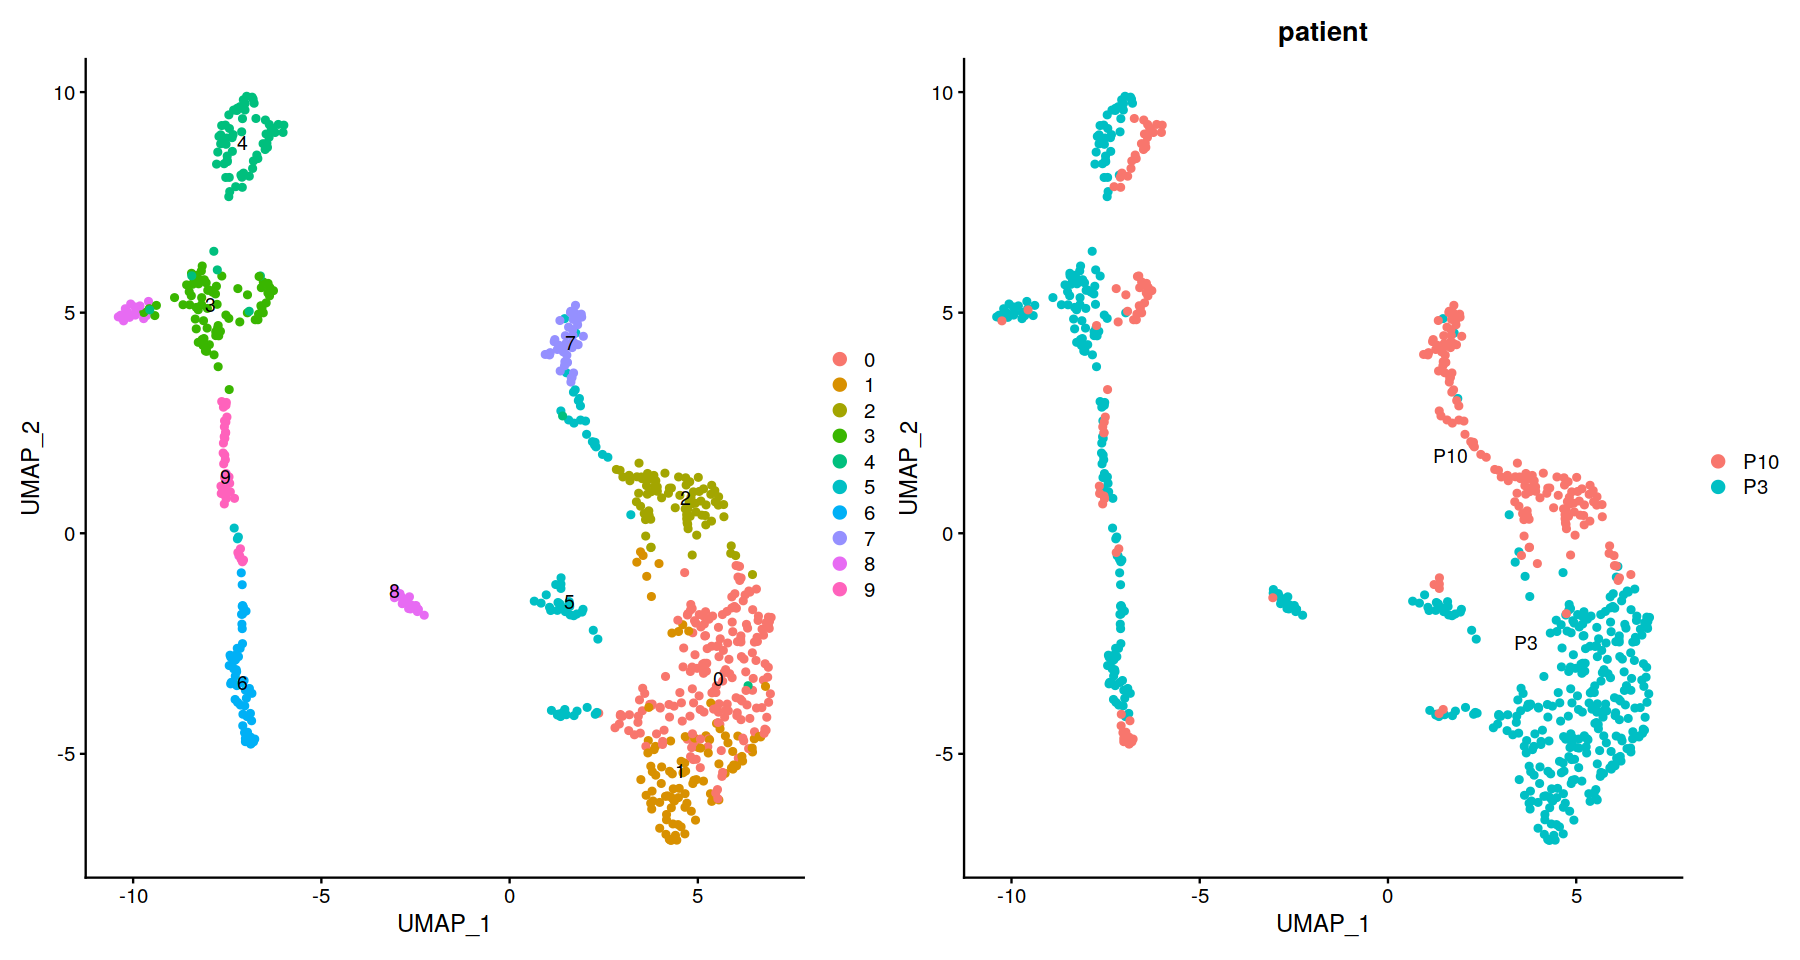

In [195]:
options(repr.plot.width=15, repr.plot.height=8)
plot_clusters <- DimPlot(covid_p3_p10, label = TRUE, pt.size=1.5)
plot_patient <- DimPlot(covid_p3_p10, label = TRUE, pt.size=1.5, group.by = "patient")
plot_clusters + plot_patient

As it is possible to see in the previows plot, the cluster number 4 has expressed genes both from patients 3 and 10. So, let's take this cluster as example to find gene markers.

In [196]:
patient_splitted <- SplitObject(covid_p3_p10, split.by = "patient")
p3_markers <- FindAllMarkers(object = patient_splitted$P3)
p10_markers <- FindAllMarkers(object = patient_splitted$P10)

p3_markers[["patient"]] = "P3"
dim(p3_markers)
head(p3_markers)

p10_markers[["patient"]] = "P10"
dim(p10_markers)
head(p10_markers)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 8

Calculating cluster 9

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



[1] 10784     8

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,patient
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
FCN1,1.636022e-46,1.465408,1.000,0.511,2.808886e-42,0,FCN1,P3
LYZ,4.339633e-46,1.455791,1.000,0.577,7.450717e-42,0,LYZ,P3
S100A9,1.141930e-43,1.699051,1.000,0.598,1.960580e-39,0,S100A9,P3
PTPRCAP,3.027966e-43,-2.696618,0.027,0.677,5.198716e-39,0,PTPRCAP,P3
S100A6,6.478775e-43,1.150365,1.000,0.958,1.112341e-38,0,S100A6,P3
TSPO,5.388758e-41,1.145761,1.000,0.849,9.251958e-37,0,TSPO,P3


[1] 7527    8

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,patient
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
NTNG2,2.391597e-21,0.6581306,0.4,0.000,4.106133e-17,0,NTNG2,P10
CASC8,1.251663e-14,0.6883229,0.4,0.004,2.148980e-10,0,CASC8,P10
OXTR,2.415820e-11,0.4155190,0.2,0.000,4.147721e-07,0,OXTR,P10
AC124045.1,2.415820e-11,0.4155190,0.2,0.000,4.147721e-07,0,AC124045.1,P10
CCIN,2.415820e-11,0.4155190,0.2,0.000,4.147721e-07,0,CCIN,P10
LDLRAD3,2.415820e-11,0.4155190,0.2,0.000,4.147721e-07,0,LDLRAD3,P10


In order to work with a single object, this following code bind p3 and p10 markers.

In [197]:
p3_p10_markers <- rbind(p3_markers, p10_markers)
dim(p3_p10_markers) # dimension of concatenated p3 and p10 markers
sample_n(p3_p10_markers, 5) # show a random sample of size = 5

[1] 18311     8

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,patient
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
PTPN7.21,2.027962e-06,1.0061693,0.750,0.206,0.03481807,9,PTPN7,P10
CAVIN2,3.084888e-05,2.3530956,0.184,0.038,0.52964438,5,CAVIN2,P3
TAP11,1.324054e-04,0.7690952,0.818,0.490,1.00000000,3,TAP1,P10
SLC15A3.4,3.894522e-03,-0.5192897,0.000,0.259,1.00000000,9,SLC15A3,P3
POLR2H,6.936801e-03,0.2677182,0.395,0.218,1.00000000,8,POLR2H,P3


Now, it is possible to filter markers of both patients only for cluster number 4.

In [200]:
cluster_4_markers <- p3_p10_markers[which(p3_p10_markers['cluster']=="4"),]
sample_n(cluster_4_markers, 5) # show a random sample of size = 5                                             

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,patient
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
RPL391,1.939209e-07,0.4187394,1.000,1.000,0.003329427,4,RPL39,P10
DPYD.21,3.800922e-03,0.3400668,0.750,0.416,1.000000000,4,DPYD,P10
IFITM1.3,6.425697e-07,0.5764313,0.929,0.641,0.011032279,4,IFITM1,P3
MLLT6.1,2.558144e-04,0.4630297,0.381,0.179,1.000000000,4,MLLT6,P3
RPS21.21,1.295424e-03,0.2755875,1.000,1.000,1.000000000,4,RPS21,P10


Now, we can group the expressed genes as "Not Significant", "Significant", "FoldChange", and "Significant&FoldChange" depending on the values of p-value and fold change.

In [202]:
# Preliminarly grouping all genes as "Not Significant"
cluster_4_markers["group"] <- "Not Significant"
# Change the grouping for the entries with significance but not a large enough Fold change
cluster_4_markers[which(
    cluster_4_markers['p_val_adj'] < 0.05 & 
    abs(cluster_4_markers['avg_log2FC']) < 1 ),"group"] <- "Significant"
# Change the grouping for the entries a large enough Fold change but not a low enough p value
cluster_4_markers[which(
    p3_p10_markers['p_val_adj'] > 0.05 & 
    abs(p3_p10_markers['avg_log2FC']) > 1 ),"group"] <- "FoldChange"
# Change the grouping for the entries with both significance and large enough fold change
cluster_4_markers[which(
    cluster_4_markers['p_val_adj'] < 0.05 & 
    abs(cluster_4_markers['avg_log2FC']) > 1 ),"group"] <- "Significant&FoldChange"
# Find and label the top peaks ordered by significance
top_peaks <- cluster_4_markers[which(
    cluster_4_markers['group']=="Significant&FoldChange", 
    order(cluster_4_markers['p_val_adj'])),][1:10,]
head(top_peaks, n = 10L)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,patient,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
IL7R.3,2.602956e-11,1.0289561,0.548,0.137,4.469016e-07,4,IL7R,P3,Significant&FoldChange
MYOM2.3,1.584255e-09,1.0930703,0.333,0.063,2.720007e-05,4,MYOM2,P3,Significant&FoldChange
GNLY.3,2.048709e-09,1.1831702,0.476,0.122,3.517429e-05,4,GNLY,P3,Significant&FoldChange
CST7.3,2.092453e-09,1.0533877,0.500,0.137,3.592533e-05,4,CST7,P3,Significant&FoldChange
NKG7.2,8.888614e-07,1.0887508,0.571,0.236,1.526086e-02,4,NKG7,P3,Significant&FoldChange
IL7R.21,1.283616e-10,1.1704016,0.679,0.139,2.203840e-06,4,IL7R,P10,Significant&FoldChange
LINC00861.21,9.643755e-10,1.1019899,0.607,0.134,1.655736e-05,4,LINC00861,P10,Significant&FoldChange
IL32.3,2.611711e-15,0.3920505,0.929,0.222,4.484046e-11,4,IL32,P3,Significant
IL32.3.1,2.611711e-15,0.3920505,0.929,0.222,4.484046e-11,4,IL32,P3,Significant


Finally, we can build a plot highlighting the seven genes that were grouped as significant "Significant&FoldChange".

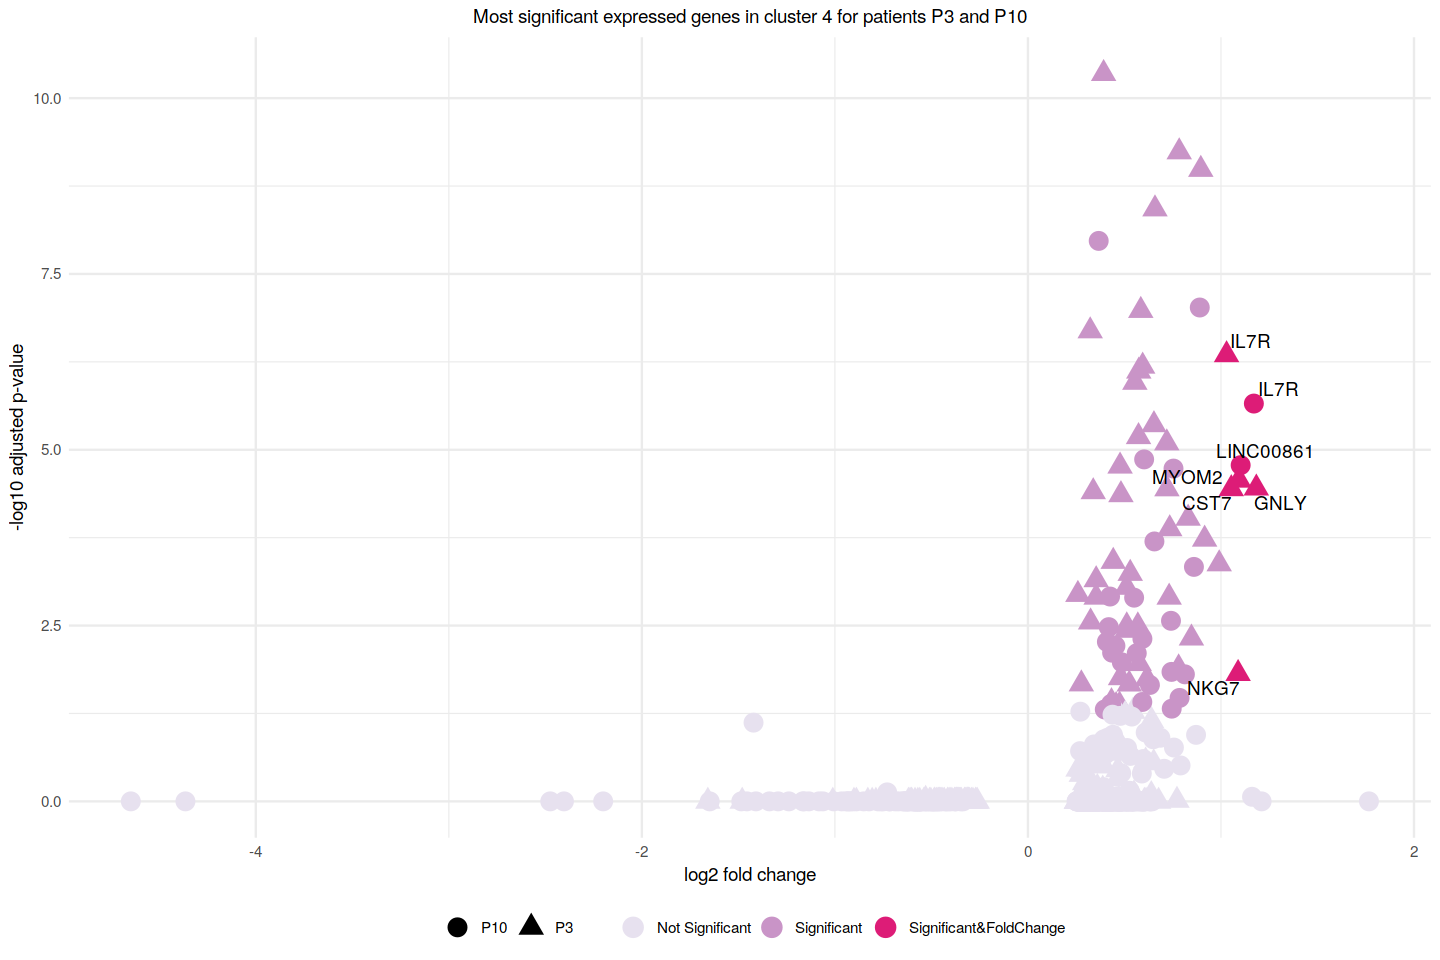

In [205]:
options(repr.plot.width=12, repr.plot.height=8)
p3_p10_plot <- ggplot(na.omit(cluster_4_markers)) +
  geom_point(aes(x = avg_log2FC, y = -log10(p_val_adj), colour = group, shape = patient), size = 5) +
  geom_text_repel(data = top_peaks[1:7,], aes(x = avg_log2FC, y = -log10(p_val_adj), label = gene))+
  scale_color_brewer(palette = "PuRd")+
  ggtitle("Most significant expressed genes in cluster 4 for patients P3 and P10")+
  xlab("log2 fold change") + 
  ylab("-log10 adjusted p-value") +
  theme_minimal()+
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1))) 
p3_p10_plot